# VARIATIONAL QUANTUM CLASSIFIER
- program to create an implement a variational algorithm that creates a decision boundary between 2 classes.
- We use 2 classes from the MNIST dataset

In [ ]:
!pip install qiskit-aer
!pip install --upgrade matplotlib==3.2.0
!pip install --upgrade pandas==1.0.4
!pip install --upgrade qiskit==0.19.6
!pip install qiskit-qcgpu-provider
!pip install --upgrade plotly==4.9.0
pip install qiskit-algorithms
pip install tensorflow
pip install qiskit-machine-learning

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer


from qiskit import *
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram
%matplotlib inline
import matplotlib.pyplot as plt

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
import numpy as np
import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.primitives import Sampler, Estimator
#from qiskit.algorithms.optimizers import COBYLA  # Moved from Aqua
from qiskit_machine_learning.algorithms.classifiers import VQC  # Moved to qiskit_machine_learning
from sklearn.model_selection import train_test_split

#from qiskit_machine_learning.datasets import split_dataset_to_data_and_labels  # Moved to qiskit_machine_learning



# The the write_and_run() magic function creates a file with the content inside the cell that it is run. 

from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [2]:
class_a = int(input("enter class 1 which you want to classify"))
class_b = int(input("enter class 2 which you want to classify"))

enter class 1 which you want to classify 1
enter class 2 which you want to classify 0


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Choose two classes
class_1, class_2 = class_a, class_b  # Modify as needed

# Filter dataset
train_mask = np.isin(y_train, [class_1, class_2])
test_mask = np.isin(y_test, [class_1, class_2])

x_train_filtered = x_train[train_mask].reshape(-1, 28 * 28)  # Flatten images
y_train_filtered = y_train[train_mask]

x_test_filtered = x_test[test_mask].reshape(-1, 28 * 28)
y_test_filtered = y_test[test_mask]

# Combine labels and features into a single dataset
data = np.column_stack((y_train_filtered, x_train_filtered))

# Extracting labels and features using the same variable names as your original dataset
data_labels = data[:, :1].reshape(data.shape[0],)
data_features = data[:, 1:]

# Save dataset
np.savetxt("dataset_{}_{}.csv".format(class_1, class_2), data, delimiter=",")

# Print shape for verification
print(f"Data Shape: {data.shape}")
print(f"Labels Shape: {data_labels.shape}")
print(f"Features Shape: {data_features.shape}")


Data Shape: (12665, 785)
Labels Shape: (12665,)
Features Shape: (12665, 784)


In [4]:
data_features_copy = data_features

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
data_features = pca.fit_transform(data_features_copy)
data = np.column_stack((data_labels,data_features))

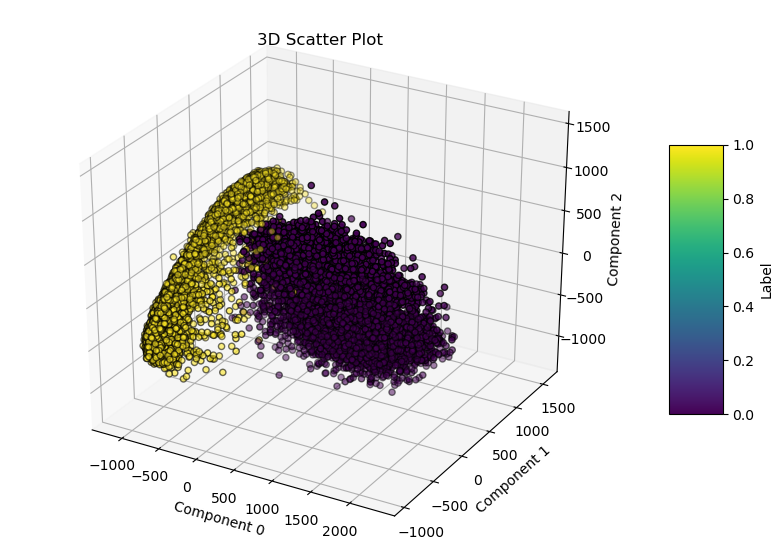

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Creating a dataframe (assuming data_features and data_labels are already defined)
df = pd.DataFrame({'Component 0': data_features[:, 0], 
                   'Component 1': data_features[:, 1], 
                   'Component 2': data_features[:, 2], 
                   'label': data_labels})

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for different labels
scatter = ax.scatter(df['Component 0'], df['Component 1'], df['Component 2'], 
                     c=df['label'], cmap='viridis', edgecolor='k')

# Labels
ax.set_xlabel("Component 0")
ax.set_ylabel("Component 1")
ax.set_zlabel("Component 2")
ax.set_title("3D Scatter Plot")

# Show color bar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label("Label")

# Show plot
plt.show()


## EXTRACTING THE TRAINING SET
data already reduced in dimension but still 12000 sized will take hours , we use subset of it

In [7]:
# Percentage of corpus considered for training
corp_perc = 2

# Calculating the total number of samples
corp_split = int(corp_perc * data.shape[0] // 100)

# Choosing random samples from data points corresponind to four and nine
four_indices = np.random.choice(np.arange(data.shape[0]//2), corp_split//2, replace=False)
nine_indices = np.random.choice(np.arange(data.shape[0]//2, data.shape[0]), corp_split//2, replace=False)
my_data_four = np.copy(data[four_indices])
my_data_nine = np.copy(data[nine_indices])

# Forming data set with samples of fours and nines
my_data = np.concatenate((my_data_four, my_data_nine))
test_perc = 5
semi_split = int(test_perc*my_data.shape[0]//200)

# Creating training and testing input dictionaries
training_input = {'A': my_data_four[:-semi_split, 1:], 'B': my_data_nine[:-semi_split, 1:]}
test_input = {'A': my_data_four[-semi_split:, 1:], 'B': my_data_nine[-semi_split:, 1:]}
testing_input = np.concatenate((my_data_four[-semi_split:, 1:], my_data_nine[-semi_split:, 1:]))
testing_labels = np.concatenate((my_data_four[-semi_split:, :1], my_data_nine[-semi_split:, :1]))
training_features = np.concatenate((my_data_four[:-semi_split, 1:], my_data_nine[:-semi_split, 1:]))
training_labels = np.concatenate((np.zeros(len(my_data_four[:-semi_split])), np.ones(len(my_data_nine[:-semi_split]))))

test_features = np.concatenate((my_data_four[-semi_split:, 1:], my_data_nine[-semi_split:, 1:]))
test_labels = np.concatenate((np.zeros(len(my_data_four[-semi_split:])), np.ones(len(my_data_nine[-semi_split:]))))


## BUILDING A FEATURE MAP
we use feature_map() function to build the feature map , using 2 reps of each feature map

In [8]:
def feature_map(i): 
    from qiskit import QuantumCircuit
    from qiskit.circuit import ParameterVector
    
    reps = 3
    num_qubits = 3    
    feature_map = QuantumCircuit(num_qubits)
    x = ParameterVector('x', length=num_qubits)

    if i == 1:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
            for i in range(num_qubits):
                for j in range(i + 1, num_qubits):
                    feature_map.cx(i, j)
                    feature_map.p(x[i] * x[j], j)
                    feature_map.cx(i, j)
    elif i == 2:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.h(i)
            for i in range(num_qubits - 1):
                feature_map.cz(i, i+1)
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
            for i in range(num_qubits-1, 0, -1):
                feature_map.cz(i, i-1)
            for i in range(num_qubits):
                feature_map.h(i)
    elif i == 3:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for i in range(num_qubits-1, 0, -1):
                feature_map.cx(i, i-1)
    elif i == 4:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for i in range(num_qubits-1, 0, -1):
                feature_map.cz(i, i-1)
    elif i == 5:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for i in range(num_qubits-1, 0, -1):
                feature_map.rz(x[i-1], i-1)
                feature_map.cx(i, i-1)
                feature_map.rz(x[i-1], i-1)
    elif i == 6:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for i in range(num_qubits-1, 0, -1):
                feature_map.rx(x[i-1], i-1)
                feature_map.cx(i, i-1)
                feature_map.rx(x[i-1], i-1)
    elif i == 7:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for control in range(num_qubits-1, -1, -1):
                for target in range(num_qubits-1, -1, -1):
                    if control != target:
                        feature_map.rz(x[target], target)
                        feature_map.cx(control, target)
                        feature_map.rz(x[target], target)
    elif i == 8:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for control in range(num_qubits-1, -1, -1):
                for target in range(num_qubits-1, -1, -1):
                    if control != target:
                        feature_map.rx(x[target], target)
                        feature_map.cx(control, target)
                        feature_map.rx(x[target], target)
    elif i == 9:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            for control in range(num_qubits-1, 0, -1):
                target = control - 1
                feature_map.rz(x[target], target)
                feature_map.cx(control, target)
                feature_map.rz(x[target], target)
    elif i == 10:
        for _ in range(reps):
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            feature_map.barrier()
            for control in range(num_qubits-1, 0, -1):
                target = control - 1
                feature_map.rx(x[target], target)
                feature_map.cx(control, target)
                feature_map.rx(x[target], target)
                feature_map.barrier()
            for i in range(num_qubits):
                feature_map.rx(x[i], i)
                feature_map.rz(x[i], i)
            feature_map.barrier()
    return feature_map

In [9]:

# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import  RealAmplitudes, EfficientSU2, TwoLocal, NLocal
    
def variational_circuit():
    # BUILD VARIATIONAL CIRCUIT HERE - START
    
    # import required qiskit libraries if additional libraries are required
    
    # build the variational circuit
    # var_circuit = EfficientSU2(3, entanglement='linear', reps=2, insert_barriers=True)
    var_circuit = TwoLocal(3, ['ry', 'rz'], ['cx'], entanglement='linear', reps=4, insert_barriers=True)
    # BUILD VARIATIONAL CIRCUIT HERE - END
    
    # return the variational circuit which is either a VaritionalForm or QuantumCircuit object
    return var_circuit

## CHOOSING A CLASSICAL OPTIMIZER
we use the cobyla optimizer (can change to adam and spsa)

In [10]:
def classical_optimizer():
    # Import the required classical optimizer from qiskit_algorithms.optimizers
    from qiskit_algorithms.optimizers import ADAM, SPSA, COBYLA
    
    # Create an optimizer object
    cls_opt = COBYLA(maxiter=100, disp=True, tol=1e-6)
    # cls_opt = ADAM(maxiter=250, lr=1e-2, beta_1=0.9, beta_2=0.9, tol=1e-6)
    # cls_opt = SPSA(maxiter=250)
    
    return cls_opt


In [11]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

## VQC OPTIMIZATION 
done by creating an instance of the VQC class

In [ ]:
import time
from qiskit_aer import Aer
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC

# Set a fixed seed for reproducibility
seed = 10598

# Creating the feature map and variational ansatz circuits
feature_map_circuit = feature_map(2)
var_form_circuit = variational_circuit()

# Define the sampler instead of quantum_backend
sampler = Sampler()

# Create the VQC instance
vqc = VQC(
    optimizer=classical_optimizer(),
    feature_map=feature_map_circuit,
    ansatz=var_form_circuit, 
    callback=call_back_vqc,
    sampler=sampler 
)

# Measure execution time
start = time.process_time()

# Train the model using the 'fit' method
vqc.fit(training_features, training_labels)

# Test the model using 'predict'
predictions = vqc.predict(test_features)

# Compute accuracy
accuracy = np.mean(predictions == test_labels)  # Ensure `test_labels` is defined

# Output execution time and accuracy
print("Time taken: {:.4f} seconds".format(time.process_time() - start))
print("Testing success ratio: {:.2f}%".format(accuracy * 100))
